# Configure Tensorflow for GPU
## (Currently using Mobile RTX 2060)

In [1]:
# Importing tensorflow (v2.5) and checking availabilty of GPU

import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
# Checking current status of GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Allocating a fraction (here 50%) of GPU memory for tensorflow

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Model Building for Inception V3

## Part 1- Import libraries 

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Part 2- Building model

In [5]:
# Re-size all the images to this

IMAGE_SIZE = [224, 224]

train_path = 'Downloads/crop_data_set/train'
valid_path = 'Downloads/crop_data_set/test'

In [6]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of inception
# Here we will be using imagenet weights (it helps the model converge in less epochs)

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Note: include_top=False to exclude top and bottom layer of the model for training our own model.

In [7]:
# Note: Don't train existing weights (layer.trainable= False , want to use all weights)

for layer in inception.layers:
    layer.trainable = False

In [8]:
# Fetching list of output classes (categories)

folders = glob('Downloads/crop_data_set/train/*')
classes=list(folders)
folders

['Downloads/crop_data_set/train\\Pepper_bell___Bacterial_spot',
 'Downloads/crop_data_set/train\\Pepper_bell___healthy',
 'Downloads/crop_data_set/train\\Potato___Early_blight',
 'Downloads/crop_data_set/train\\Potato___healthy',
 'Downloads/crop_data_set/train\\Potato___Late_blight',
 'Downloads/crop_data_set/train\\Tomato___Bacterial_spot',
 'Downloads/crop_data_set/train\\Tomato___Early_blight',
 'Downloads/crop_data_set/train\\Tomato___healthy',
 'Downloads/crop_data_set/train\\Tomato___Late_blight',
 'Downloads/crop_data_set/train\\Tomato___Leaf_Mold',
 'Downloads/crop_data_set/train\\Tomato___Septoria_leaf_spot',
 'Downloads/crop_data_set/train\\Tomato___Spider_mites Two-spotted_spider_mite',
 'Downloads/crop_data_set/train\\Tomato___Target_Spot',
 'Downloads/crop_data_set/train\\Tomato___Tomato_mosaic_virus',
 'Downloads/crop_data_set/train\\Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [9]:
# Our layer - can add more if needed

x = Flatten()(inception.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# Creating a model object

model = Model(inputs=inception.input, outputs=prediction)

In [11]:
# Viewing the structure of the model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# Telling the model what cost and optimization method to use

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## Step 3- Data Preprocessing

In [13]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing the Training set
# Applying data agumentation technique (with rescaling train data set images)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Rescaling test data set images

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
training_set = train_datagen.flow_from_directory('Downloads/crop_data_set/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# Note: class_mode is 'binary' for 2 categories and is 'categorical' for more than 2 categories 

Found 22346 images belonging to 15 classes.


In [15]:
# Preprocessing the Test set
# Note: Make sure to provide the same target size as initialied for the image size

test_set = test_datagen.flow_from_directory('Downloads/crop_data_set/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5685 images belonging to 15 classes.


## Step 4- Training custom Inception V3 model

In [16]:
# Fitting the model

r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)
# Note: It will take some time to execute (With mobile RTX 2060 and 15 epochs it took ~45 mins.)

Epoch 1/15
699/699 [==============================] - 230s 318ms/step - loss: 3.3047 - accuracy: 0.6905 - val_loss: 2.8317 - val_accuracy: 0.7439
Epoch 2/15
699/699 [==============================] - 216s 308ms/step - loss: 2.4063 - accuracy: 0.7976 - val_loss: 2.9448 - val_accuracy: 0.7727
Epoch 3/15
699/699 [==============================] - 224s 320ms/step - loss: 2.2064 - accuracy: 0.8318 - val_loss: 2.5602 - val_accuracy: 0.8241
Epoch 4/15
699/699 [==============================] - 218s 312ms/step - loss: 2.2820 - accuracy: 0.8456 - val_loss: 3.0154 - val_accuracy: 0.8195
Epoch 5/15
699/699 [==============================] - 221s 316ms/step - loss: 2.1502 - accuracy: 0.8609 - val_loss: 3.5590 - val_accuracy: 0.8070
Epoch 6/15
699/699 [==============================] - 219s 314ms/step - loss: 2.0465 - accuracy: 0.8727 - val_loss: 2.8448 - val_accuracy: 0.8405
Epoch 7/15
699/699 [==============================] - 219s 313ms/step - loss: 1.9205 - accuracy: 0.8819 - val_loss: 3.2562 -

# Plotting loss and accuracy

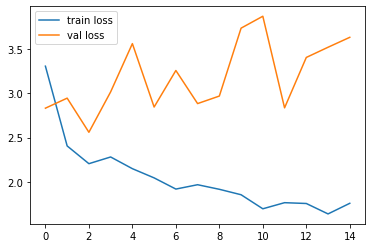

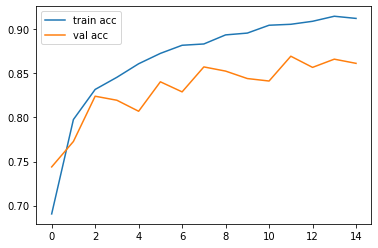

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot the loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Saving custom build model

In [18]:
# Saving it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [19]:
y_pred = model.predict(test_set)


In [20]:
y_pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.6569645e-21, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.1455527e-07, 1.9995806e-34],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [21]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [22]:
y_pred

array([ 7,  9,  5, ..., 12,  8, 13], dtype=int64)

# Import saved model

In [4]:
# Importing libraries for loading our saved model

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [5]:
model=load_model('model_inception.h5')

In [6]:
train_path = 'Downloads/crop_data_set/train'
valid_path = 'Downloads/crop_data_set/test'

# Make single prediction

In [7]:
# Importing some essential libraries

from glob import iglob
import numpy as np
import matplotlib.pyplot as plt

# Storing the list of folders

folders = iglob('Downloads/crop_data_set/train/*')
classes=list(folders)

# User defined function for making predictions

def model_predict(img_path, model):
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Preprocessing the image
    x = image.img_to_array(img)
    # Scaling
    x=x/255
    x = np.expand_dims(x, axis=0)
     
    preds = model.predict(x)
    preds=np.argmax(preds, axis=1)
    plt.imshow(img)
    plt.figure(0)    
    plt.show()
    
    # Be careful how the trained model deals with the input image, otherwise it won't make correct prediction.
    if preds==0:
        preds="The Disease is Pepper__bell___Bacterial_spot"
    elif preds==1:
        preds="Pepper__bell___healthy"
    elif preds==2:
        preds="The Disease is Potato___Early_blight"
    elif preds==3:
        preds="The Disease is Potato___Late_blight"
    elif preds==4:
        preds=" Potato___healthy"
    elif preds==5:
        preds="The Disease is Tomato__Bacterial_spot"
    elif preds==6:
        preds="The Disease is Tomato__Tomato_Early_blight"
    elif preds==7:
        preds="The Disease is Tomato_Late_blight"
    elif preds==8:
        preds="The Disease is Tomato_Leaf_Mold"
    elif preds==9:
        preds="The Disease is Tomato_Septoria_leaf_spot"
    elif preds==10:
        preds="The Disease is Tomato_Spider_mites Two-spotted"
    elif preds==11:
        preds="The Disease is Tomato_Target_Spot"
    elif preds==12:
        preds="The Disease is Tomato_Yellow_Leaf_Curl_Virus"
    elif preds==13:
        preds="The Disease is Tomato_mosaic_virus"
    elif preds==14:
        preds="Tomato_heathy"
    
    return preds

## Displaying prediction result

Downloads/crop_data_set/test/Tomato___healthy/0a334ae6-bea3-4453-b200-85e082794d56___GH_HL Leaf 310.1_flipTB.JPG


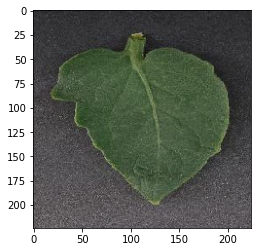

<Figure size 432x288 with 0 Axes>

Tomato_heathy


In [9]:
# Predicting the result

preds = model_predict('Downloads/crop_data_set/test/Tomato___healthy/0a334ae6-bea3-4453-b200-85e082794d56___GH_HL Leaf 310.1_flipTB.JPG', model)
print(preds)